This jupyter notebook was modified 2019.9.18 by PVT from a template received from Bob Chen in the Ken Lau Lab.
    --> This notebook is intended to analyze scRNAseq data; specifically files containing preprocessed cells where the rows are barcodes and the columns are genes. 
    
## Functions/Classes:
##### ConvertCsvToHdf5 - function that takes the csv file and reformats it into a hdf5 file
##### libdata - object that stores the scrnaseq data
##### dimension_reduction - object that performs dimensionality reduction (PCA, tSNE, UMAP)
##### gate_thresh - object that takes reduced data and either gates out unwanted cells or performs several visualization options

## Convert Counts_Matrix into .hdf5 file 

In [7]:
import h5py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import umap
from pydpc import Cluster
%matplotlib inline
import scipy.io
import sys

ModuleNotFoundError: No module named 'pydpc'

In [13]:
def ConvertCsvToHdf5(filename,new_filename):
    
    # Make sure that the new_filename includes .hdf5 at the end
    
    # load file and count nrows & ncols
    sample = pd.read_csv(filename);
    sample = sample.drop(['Unnamed: 0'], 1);
    nrows = len(sample)
    ncols = np.size(sample,1)
    
    # Retrieve Barcodes (row titles)
    barcodes = sample.loc[:,'barcode'].tolist()
    
    # Reformat Barcodes
    ascii_barcodes = [n.encode("ascii", "ignore") for n in barcodes];
    
    # Retrieve Transcripts (col titles)
    transcripts = list(sample.columns)
    transcripts.pop(0) # remove 'barcodes' from transcript list
    
    # Reformt Transcripts List
    ascii_transcripts = [n.encode("ascii", "ignore") for n in transcripts];
    
    # Reformat Counts Matrix
    counts_list = sample.values.tolist(); # convert to list
    counts_array = np.array(counts_list); # convert to np.array
    counts_array_reduced = counts_array[:,1:]; # trim first column
    final_counts = np.int64(counts_array_reduced); # convert to int64 datatype
    
    # ReWrite into HDF5 File
    
    f = h5py.File(new_filename, "w")
    dset1 = f.create_dataset("Barcodes", (nrows,), dtype='a16', chunks=True)
    dset2 = f.create_dataset("Top_Counts", (nrows,ncols-1), dtype='int64', chunks=True)
    dset3 = f.create_dataset("Transcripts", (ncols-1,), dtype='a24', chunks=True)
    
    dset1[...] = ascii_barcodes;
    dset2[...] = final_counts;
    dset3[...] = ascii_transcripts;
    
    f.close()

    return [nrows, ncols] 


In [92]:
def ConcatenateToHdf5(csv1, csv2, new_filename):
    sample1 = pd.read_csv(csv1);
    sample1 = sample1.drop(['Unnamed: 0'], 1);
    barcodes1 = sample1.loc[:,'barcode'].tolist()
    nrows1 = len(sample1)
    ncols = np.size(sample1,1)
    
    sample2 = pd.read_csv(csv2);
    sample2 = sample2.drop(['Unnamed: 0'], 1);
    barcodes2 = sample2.loc[:,'barcode'].tolist()
    nrows2 = len(sample2)
    
    # Transcripts reformating
    transcripts = list(sample1.columns)
    transcripts.pop(0)
    ascii_transcripts = [n.encode("ascii", "ignore") for n in transcripts];

    # Counts Concatenation
    counts_list1 = sample1.values.tolist(); # convert to list
    counts_list2 = sample2.values.tolist(); 

    counts_array1 = np.array(counts_list1); # convert to np.array
    counts_array2 = np.array(counts_list2);
    
    combined_counts = np.concatenate((counts_array1, counts_array2));
    
    counts_array_reduced = combined_counts[:,1:]; # trim first column
    final_counts = np.int64(counts_array_reduced); # convert to int64 datatype
    
    # Concatenate Barcodes
    combined_barcodes = np.concatenate((barcodes1,barcodes2));
    ascii_barcodes = [n.encode("ascii", "ignore") for n in combined_barcodes];

    nrows = nrows1 + nrows2;
    
    f = h5py.File(new_filename, "w")
    dset1 = f.create_dataset("Barcodes", (nrows,), dtype='a16', chunks=True)
    dset2 = f.create_dataset("Top_Counts", (nrows,ncols-1), dtype='int64', chunks=True)
    dset3 = f.create_dataset("Transcripts", (ncols-1,), dtype='a24', chunks=True)
    
    dset1[...] = ascii_barcodes;
    dset2[...] = final_counts;
    dset3[...] = ascii_transcripts;
    
    f.close()

    return [nrows1, nrows2]

In [14]:
ConvertCsvToHdf5('s3_quality_CAF_gene-filtered-1.csv', 'fuck.hdf5')

[95, 38017]

In [112]:
ConcatenateToHdf5('s3_quality_endothelial_gene-filtered-1.csv', 's4_quality_endothelial_gene-filtered-1.csv', 's3s4endothelial.hdf5')

[13, 16]

## Begin Cell Selection & Normalization Process

## Class Definitions

In [16]:
class lib_data(object):
    
    def size_rank(self): #this needed to be defined before the __init__ because it needs to be run during the __init__ if the initializing data is in dataframe format
        self.lib_size = np.sum(self.lib_counts,axis=1) #calculate 
        self.lib_rank = np.argsort(self.lib_size)[::-1]
        self.mt_mouse_mask = pd.Series( self.lib_counts.columns).str.contains('mt-').values # startswith() is case sensitive
        self.mt_human_mask = pd.Series( self.lib_counts.columns).str.contains('MT-').values # startswith() is case sensitive
        self.lib_rank_inflec = None 
        
    def __init__(self,hdf5_file = None,lib_counts = None):
        self.hdf5 = hdf5_file
        self.lib_counts = lib_counts #main array of count data
        if (hdf5_file == None):
            self.size_rank()

    def hdf5_to_counts(self):
        #need to put some kind of checker here to make sure that first index of datasets is actually counts and not vice versa 
        self.lib_counts=pd.DataFrame(self.hdf5['Top_Counts'][()])
        transcriptsIn=pd.DataFrame(self.hdf5['Transcripts'][()])
        barcodesIn=pd.DataFrame(self.hdf5['Barcodes'][()])
        transcriptsIn=list(transcriptsIn[0].apply(lambda x: x.decode('utf-8'))) #decode bytes to utf-8
        barcodesIn=list(barcodesIn[0].apply(lambda x: x.decode('utf-8'))) #decode bytes to utf-8
        self.lib_counts.columns=transcriptsIn
        self.lib_counts.index=barcodesIn
        self.size_rank()
        
    def marker_percent(self,mask):
        marker_sum = np.sum( self.lib_counts.iloc[:,mask].values, axis=1)
        return marker_sum/self.lib_size.astype(float)*100 #percent of counts that are mitochondrial given all counts in cell
           
    def find_inflection(self):
        
        cumsum=np.cumsum(self.lib_size)
        length=len(cumsum)
        x_vals=np.arange(0,length)
        secant_coef=cumsum[length-1]/length
        secant_line=secant_coef*x_vals
        secant_dist=abs(cumsum-secant_line)
        max_dist=np.where(np.max(secant_dist)==secant_dist)[0][0]
        plt.figure(figsize=(20,10))
        plt.xlabel('Fuck')
        plt.plot(np.array(cumsum), label="Cumulative Sum")
        plt.plot(np.array(secant_line), label="Secant Line")
        plt.plot(np.array(secant_dist), label="CS-SL Distance")
        plt.axvline(x=max_dist,c='red',linestyle='--',linewidth=1,label="Inflection Point")
        plt.legend()
        plt.xlabel('Cell (ID)')
        plt.ylabel('Cummulative Sum (# transcripts)')
        self.lib_rank_inflec = np.sort(np.where(self.lib_rank<max_dist)).ravel()
        print("Inflection point at {}".format(max_dist))
        
    def top_n_lib_counts(self,inflec):
        top_n_output = self.lib_counts.iloc[inflec,:]
        return top_n_output

In [235]:
class dimension_reduction(object):
    
    def __init__(self,lib_data_in,seed = 42):
        self.lib_data = lib_data_in.lib_counts
        self.lib_size = lib_data_in.lib_size
        self.lib_rank = lib_data_in.lib_rank
        self.seed = seed
        np.random.seed(self.seed)

    def normalize_arcsinh(self,cofactor):
        self.lib_data = np.arcsinh(self.lib_data.div(self.lib_size.values,axis = 'rows')*cofactor)
        
    def runPCA(self,n_pcs):
        _pca = PCA(n_components = n_pcs)
        self.PCA = _pca.fit(self.lib_data).transform(self.lib_data)
        print(_pca.explained_variance_ratio_)
        
    def runUMAP(self,n_neighbors = 10,min_dist = 0.5):
        self.UMAP = umap.UMAP(n_neighbors = n_neighbors, min_dist = min_dist, metric = 'correlation').fit_transform(self.PCA)

In [370]:
class gate_thresh(object):
    
    def __init__(self,dr_in):
        self.PCA = dr_in.PCA
        self.UMAP = dr_in.UMAP
        self.seed = dr_in.seed
        self.lib_rank = dr_in.lib_rank
        self.DPC = None
        
    def plotPCA(self):
        fig = plt.figure(figsize=(16,16))
        ax1 = fig.add_subplot(221)
        ax2 = fig.add_subplot(222)
        ax3 = fig.add_subplot(223)
        ax4 = fig.add_subplot(224)

        ax1.scatter(self.PCA[:,0],self.PCA[:,1],alpha=0.5, s=20)
        ax2.scatter(self.PCA[:,1],self.PCA[:,2],alpha=0.5, s=20)
        ax3.scatter(self.PCA[:,2],self.PCA[:,3],alpha=0.5, s=20)
        ax4.scatter(self.PCA[:,3],self.PCA[:,4],alpha=0.5, s=20)

        ax1.set_xlabel( "PC_0")
        ax1.set_ylabel( "PC_1")
        ax2.set_xlabel( "PC_1")
        ax2.set_ylabel( "PC_2")
        ax3.set_xlabel( "PC_2")
        ax3.set_ylabel( "PC_3")
        ax4.set_xlabel( "PC_3")
        ax4.set_ylabel( "PC_4")
    
    def plotUMAP(self,marker_overlay):
        cmap_rank = plt.cm.get_cmap('seismic_r')
        cmap_marker = plt.cm.get_cmap('hot')
        cmap_clust=plt.cm.get_cmap('tab20', len(self.DPC.clusters))

        fig = plt.figure(figsize=(30,10))
        ax1 = fig.add_subplot(131)
        ax2 = fig.add_subplot(132)
        ax3 = fig.add_subplot(133)
        
        rank = ax1.scatter(self.UMAP[:,0],self.UMAP[:,1],alpha=1, s=5,c = self.lib_rank,cmap = cmap_rank)
        mito = ax2.scatter(self.UMAP[:,0],self.UMAP[:,1],alpha=1, s=5,c = marker_overlay,cmap = cmap_marker)
        clust = ax3.scatter(self.UMAP[:,0],self.UMAP[:,1],alpha=1, s=5,c = self.DPC.membership,cmap = cmap_clust) 
        
        plt.colorbar(rank, ax = ax1)
        plt.colorbar(mito, ax = ax2)
        plt.colorbar(clust, ax = ax3,ticks=range(len(self.DPC.clusters)))
        
        ax1.set_xlabel("Ranking")
        ax2.set_xlabel("Marker Enrichment")
        ax3.set_xlabel("Density Peak Clustering")
        
    def plotGene(self, marker_overlay, gene_name, top_limit = -666, cmap = 'magma'):
        cmap_marker = plt.cm.get_cmap(cmap);
        fig = plt.figure(figsize=(6,6))
        plt.scatter(self.UMAP[:,0],self.UMAP[:,1],alpha=1, s=50,c = marker_overlay,cmap = cmap_marker)
        plt.colorbar()
        if top_limit != -666:
            plt.clim(0,top_limit)
        plt.xlabel("Marker Enrichment")
        plt.title(gene_name)
        return fig
    
    def runDPC(self,dr,x_cutoff,y_cutoff,force_rerun = False):
        if ((self.DPC == None) or (force_rerun == True)):
            self.DPC = Cluster(dr.astype('float64'))
        self.DPC.assign(x_cutoff,y_cutoff)
        
    def manual_gating(self,gate_out):
        clust_inds = np.delete(np.arange(0,len(self.DPC.membership),1),gate_out) # clusters that represent cells to keep
        clust_mask = np.isin(self.DPC.membership, clust_inds)
        gated_embedding = self.UMAP[clust_mask]
        gated_ranking = self.lib_rank[clust_mask]

        cmap_rank = plt.cm.get_cmap('seismic_r')
        fig = plt.figure(figsize=(10,10))
        ax1 = fig.add_subplot(111)
        rank = ax1.scatter(gated_embedding[:,0],gated_embedding[:,1],alpha=1,s=20,c = gated_ranking,cmap = cmap_rank)
        plt.colorbar(rank, ax = ax1)
        
        ax1.set_xlabel("Gated Ranking")
        
        return (clust_mask)

Possible values are: Accent, Accent_r, Blues, Blues_r, BrBG, BrBG_r, BuGn, BuGn_r, BuPu, BuPu_r, CMRmap, CMRmap_r, Dark2, Dark2_r, GnBu, GnBu_r, Greens, Greens_r, Greys, Greys_r, OrRd, OrRd_r, Oranges, Oranges_r, PRGn, PRGn_r, Paired, Paired_r, Pastel1, Pastel1_r, Pastel2, Pastel2_r, PiYG, PiYG_r, PuBu, PuBuGn, PuBuGn_r, PuBu_r, PuOr, PuOr_r, PuRd, PuRd_r, Purples, Purples_r, RdBu, RdBu_r, RdGy, RdGy_r, RdPu, RdPu_r, RdYlBu, RdYlBu_r, RdYlGn, RdYlGn_r, Reds, Reds_r, Set1, Set1_r, Set2, Set2_r, Set3, Set3_r, Spectral, Spectral_r, Wistia, Wistia_r, YlGn, YlGnBu, YlGnBu_r, YlGn_r, YlOrBr, YlOrBr_r, YlOrRd, YlOrRd_r, afmhot, afmhot_r, autumn, autumn_r, binary, binary_r, bone, bone_r, brg, brg_r, bwr, bwr_r, cividis, cividis_r, cool, cool_r, coolwarm, coolwarm_r, copper, copper_r, cubehelix, cubehelix_r, flag, flag_r, gist_earth, gist_earth_r, gist_gray, gist_gray_r, gist_heat, gist_heat_r, gist_ncar, gist_ncar_r, gist_rainbow, gist_rainbow_r, gist_stern, gist_stern_r, gist_yarg, gist_yarg_r, gnuplot, gnuplot2, gnuplot2_r, gnuplot_r, gray, gray_r, hot, hot_r, hsv, hsv_r, inferno, inferno_r, jet, jet_r, magma, magma_r, nipy_spectral, nipy_spectral_r, ocean, ocean_r, pink, pink_r, plasma, plasma_r, prism, prism_r, rainbow, rainbow_r, seismic, seismic_r, spring, spring_r, summer, summer_r, tab10, tab10_r, tab20, tab20_r, tab20b, tab20b_r, tab20c, tab20c_r, terrain, terrain_r, twilight, twilight_r, twilight_shifted, twilight_shifted_r, viridis, viridis_r, winter, winter_r

## Reading and data from .hdf5 file and initializing lib_data object

In [371]:
dataIn=h5py.File("s3s4tumors.hdf5","r")

In [372]:
list(dataIn.keys())
indrops_data=lib_data(hdf5_file=dataIn)
indrops_data.hdf5_to_counts()
indrops_data.lib_counts.head()

,0610006L08Rik,0610007P14Rik,0610009B22Rik,0610009E02Rik,0610009L18Rik,0610009O20Rik,0610010F05Rik,0610010K14Rik,0610011F06Rik,0610012D04Rik,...,snoU18,snoU2-30,snoU2_19,snoU83B,snoZ196,snoZ278,snoZ40,snoZ6,snosnR66,uc_338
bcDJPW,0,5,2,0,0,0,3,2,1,0,...,0,0,0,0,0,0,0,0,0,0
bcFADK,0,1,3,0,0,0,2,1,2,0,...,0,0,0,0,0,0,0,0,0,0
bcEFMY,0,2,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
bcAAUV,0,2,5,0,1,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
bcEPIJ,0,4,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [373]:
np.size(indrops_data.lib_counts)/38016

2152.0

In [374]:
s1 = [0]*1047;
s2 = [1]*1105;
mask = s1 + s2;

## Dimensionality Reduction for Downstream Analysis

We pass the lib_data object, indrops_data in this example, to initialize another object for data normalization and dimensionality reductions.

In [375]:
indrops_dr=dimension_reduction(indrops_data)
indrops_dr.normalize_arcsinh(1000)
indrops_dr.runPCA(100)
indrops_dr.runUMAP()

[ 0.09217561  0.04988366  0.04132118  0.02478828  0.02060696  0.01619046
  0.013403    0.0107374   0.00898493  0.0082445   0.00737655  0.00690118
  0.00628933  0.00548982  0.0052793   0.00501121  0.00491165  0.00456797
  0.0042936   0.00403965  0.0037705   0.00348939  0.00346831  0.00333171
  0.00323448  0.00311552  0.00302714  0.00286099  0.00275831  0.00272422
  0.00262033  0.00251446  0.00246912  0.00241906  0.00235876  0.00231122
  0.00224133  0.00215281  0.00210711  0.0020551   0.00201155  0.00200752
  0.00193667  0.0019074   0.00189476  0.00186589  0.00181625  0.0017732
  0.00173687  0.00172175  0.00170407  0.00167447  0.00165559  0.00164888
  0.00159932  0.00159414  0.00157268  0.00153477  0.00153029  0.00149991
  0.00147944  0.00147546  0.00146606  0.0014552   0.00144417  0.00140787
  0.00139075  0.00138007  0.00136278  0.00135393  0.00134683  0.00131567
  0.00130166  0.00129793  0.00128478  0.00127797  0.00127138  0.00125713
  0.00124676  0.00124481  0.00123901  0.00123204  0.

## Clustering and Gating Subpopulations

We pass the dimension_reduction object, indrops_dr, to initialize the clustering and gating based quality control. 

In [376]:
indrops_gt=gate_thresh(indrops_dr)

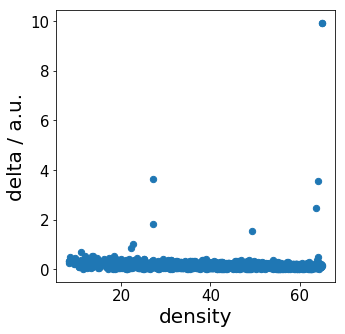

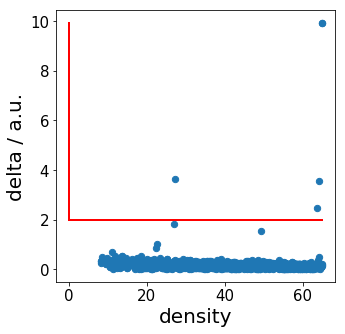

In [377]:
indrops_gt.runDPC(indrops_gt.UMAP,0.0,2.0) #the last two values are the x,y cutoffs

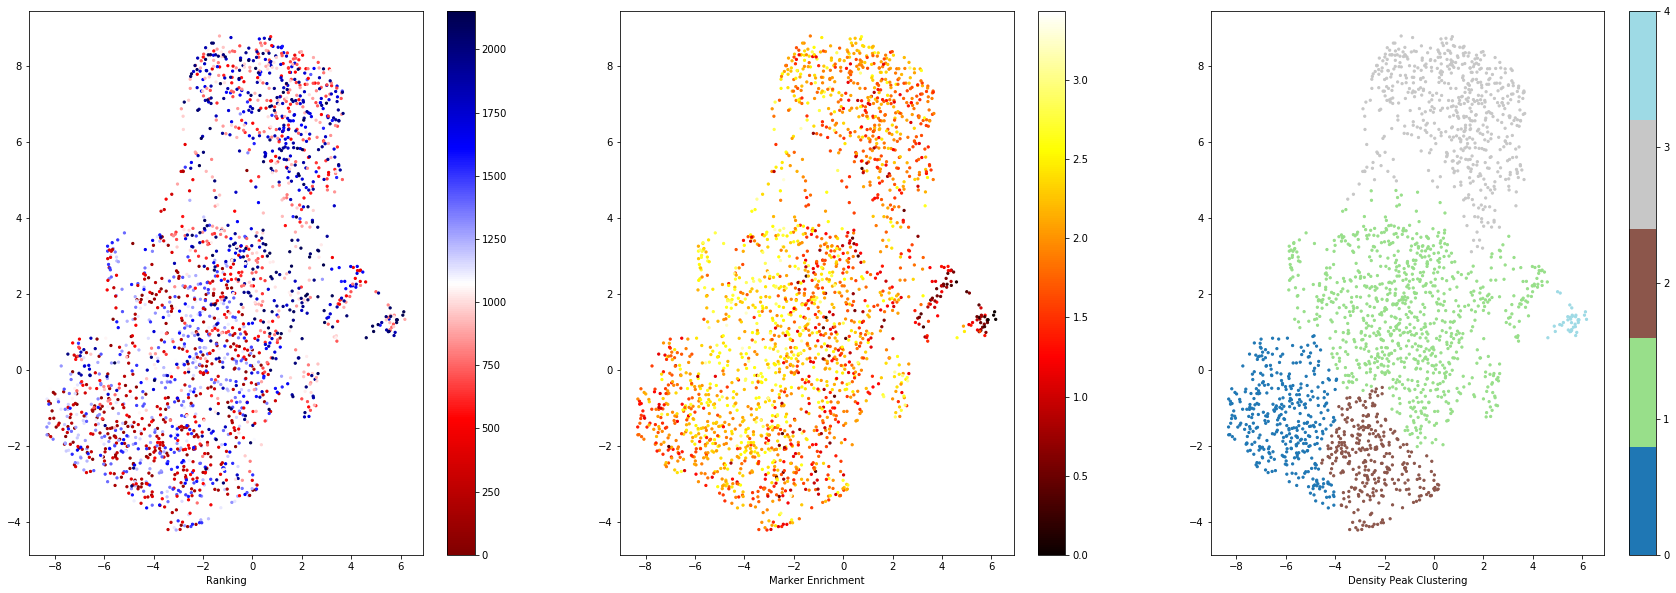

In [378]:
indrops_gt.plotUMAP(indrops_dr.lib_data[('Actb')])

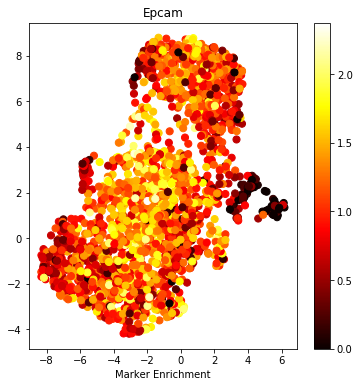

In [413]:
f = indrops_gt.plotGene(indrops_dr.lib_data[('Epcam')], 'Epcam', -666, 'hot')
f.savefig("S3_S4_Tumor/Epcam.pdf", bbox_inches='tight')

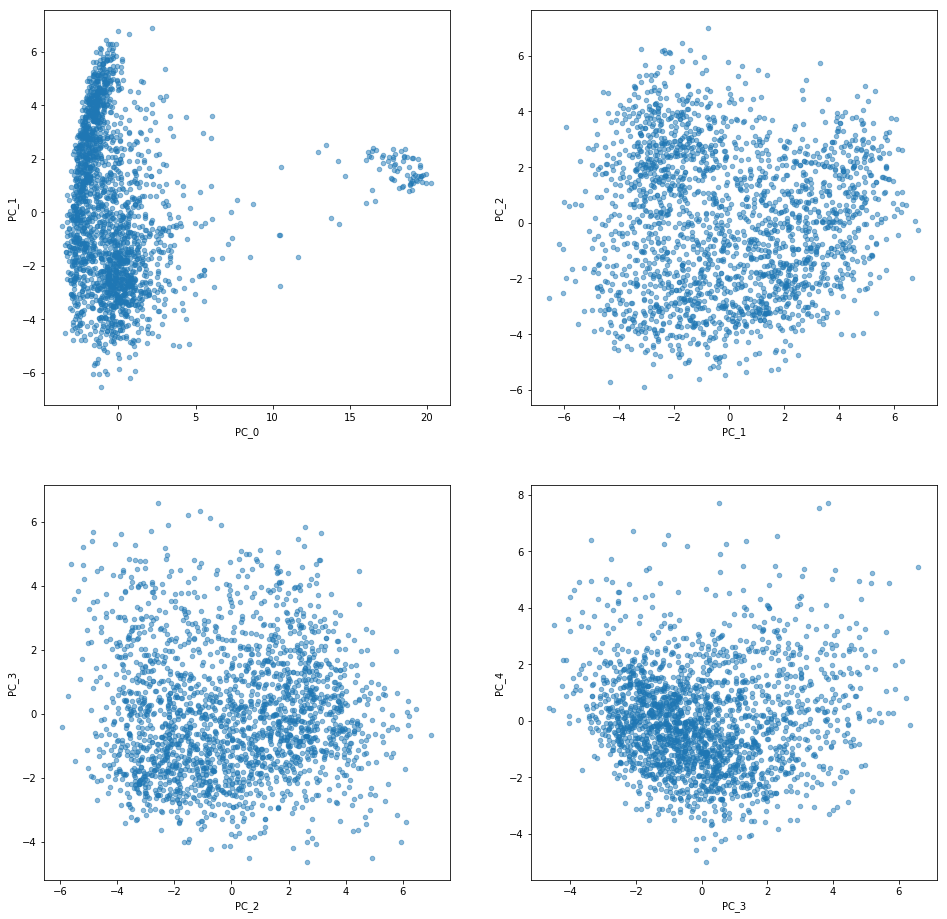

In [368]:
indrops_gt.plotPCA()

In [44]:
from collections import Counter
Counter(indrops_gt.DPC.membership)

Counter({2: 29, 0: 48, 1: 18})

In [ ]:
from collections import Counter
Counter(gated_indrops_gt.DPC.membership)

In [254]:
import pandas as pd
res = indrops_dr.lib_data[('Ppia')].tolist()
my_df = pd.DataFrame(res)
#my_df.to_csv('out_s1.csv', index=False, header=False)
np.mean(my_df)

0    1.991964
dtype: float64

## Populate a folder with individual UMAP plots masked with gene expression

In [412]:
##transcript_list = ['Krt14', 'Krt15', 'Tgm1', 'Ivl', 'Evpl', 'Cdh1', 'Itga3', 'Dsg2', 'Cldn4', 'L1cam', 'Lama3', 'Trp63', 'Grhl1', 'Grhl2', 'Grhl3', 'Ovol1', 'Ovol2', 'Esrp1', 'Esrp2'];
transcript_list = ['Cdh2','Cdh11', 'Pdgfra', 'Pdgfrb', 'Fap', 'Fn1', 'Lox', 'Loxl1', 'Col3a1', 'Col24a1', 'Mmp19', 'Mmp23', 'Ctgf', 'Snai1', 'Prrx1', 'Twist1', 'Twist2', 'Zeb1', 'Zeb2']; 
#transcript_list = ['Fxyd3', 'Sfn', 'Serinc3', 'Ucp2', 'Atp6v1b1', 'Lalba', 'Krt18', 'Neat1', 'Gm42851', 'Ly6e', 'Krt8', 'Gm20407', 'Ano1', 'Atp6v1e1', 'Folr1', 'Erf', 'Gdpd3', 'Clic6', 'Srebf1', 'Itpkc', 'Ubc', 'mt-Rnr2', 'Pnpla2', 'Gm29562', 'Ralgds', 'Csn3', 'Alyref', 'Lrg1', 'Cldn3', 'Cracr2b', 'Bcl3', 'Cd9', 'Hist4h4', 'Ldha', 'Ehd3', 'Lipa', 'Elf5', 'Ctsh', 'Btg2', 'Cyp2a5', 'Msrb1', 'Lgals3bp', 'Dusp8', 'Tcn2', 'Fam3c', 'Muc1', 'Atp6v0e', 'Fgfr1', 'Reep5', 'Csrp1']
folder_name = 'S3_S4_Tumor/EMT/Mesenchymal';
for t in transcript_list:
    f = indrops_gt.plotGene(indrops_dr.lib_data[(t)], t, -666, 'hot')
    save_loc = folder_name+'/'+t+'.pdf';
    f.savefig(save_loc, bbox_inches='tight')
    plt.close()